**Note:** This notebook was originally copied from the [MIT Deep Learning tutorial repository](https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb). However, updates have been made to ensure compatibility with current versions of the `tensorflow` library, as there have been significant changes since this tutorial was originally created.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bradleyboehmke/uc-bana-4080/blob/main/example-notebooks/tutorial_deep_learning_basics.ipynb)

---

**Additional Resources:**

- [Visit MIT Deep Learning](https://deeplearning.mit.edu)
- [View Source on GitHub](https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb)
- [Watch YouTube Videos](https://www.youtube.com/watch?v=O5xeyoRL95U&list=PLrAXtmErZgOeiKm4sgNOknGvNjby9efdf)

# Deep Learning Basics

This tutorial accompanies the [lecture on Deep Learning Basics](https://www.youtube.com/watch?list=PLrAXtmErZgOeiKm4sgNOknGvNjby9efdf&v=O5xeyoRL95U) given as part of [MIT Deep Learning](https://deeplearning.mit.edu). Acknowledgement to amazing people involved is provided throughout the tutorial and at the end. You can watch the video on YouTube:

[![Deep Learning Basics](https://i.imgur.com/FfQVV8q.png)](https://www.youtube.com/watch?list=PLrAXtmErZgOeiKm4sgNOknGvNjby9efdf&v=O5xeyoRL95U)

In this tutorial, we mention seven important types/concepts/approaches in deep learning, introducing the first 2 and providing pointers to tutorials on the others. Here is a visual representation of the seven:

![Deep learning concepts](https://i.imgur.com/EAl47rp.png)

At a high-level, neural networks are either encoders, decoders, or a combination of both. Encoders find patterns in raw data to form compact, useful representations. Decoders generate new data or high-resolution useful infomation from those representations. As the lecture describes, deep learning discovers ways to **represent** the world so that we can reason about it. The rest is clever methods that help use deal effectively with visual information, language, sound (#1-6) and even act in a world based on this information and occasional rewards (#7).

1. **Feed Forward Neural Networks (FFNNs)** - classification and regression based on features. See [Part 1](#Part-1:-Boston-Housing-Price-Prediction-with-Feed-Forward-Neural-Networks) of this tutorial for an example.
2. **Convolutional Neural Networks (CNNs)** - image classification, object detection, video action recognition, etc. See [Part 2](#Part-2:-Classification-of-MNIST-Dreams-with-Convolution-Neural-Networks) of this tutorial for an example.
3. **Recurrent Neural Networks (RNNs)** - language modeling, speech recognition/generation, etc. See [this TF tutorial on text generation](https://www.tensorflow.org/tutorials/sequences/text_generation) for an example.
4. **Encoder Decoder Architectures** - semantic segmentation, machine translation, etc. See [our tutorial on semantic segmentation](https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/tutorial_driving_scene_segmentation.ipynb) for an example.
5. **Autoencoder** - unsupervised embeddings, denoising, etc.
6. **Generative Adversarial Networks (GANs)** - unsupervised generation of realistic images, etc. See [this TF tutorial on DCGANs](https://github.com/tensorflow/tensorflow/blob/r1.11/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb) for an example.
7. **Deep Reinforcement Learning** - game playing, robotics in simulation, self-play, neural arhitecture search, etc. We'll be releasing notebooks on this soon and will link them here.

There are selective omissions and simplifications throughout these tutorials, hopefully without losing the essence of the underlying ideas. See Einstein quote...

## Part 0: Prerequisites:

We recommend that you run this this notebook in the cloud on Google Colab (see link with icon at the top) if you're not already doing so. It's the simplest way to get started. You can also [install TensorFlow locally](https://www.tensorflow.org/install/). But, again, simple is best (with caveats):

![Einstein](https://i.imgur.com/vfPDHGN.png)

[tf.keras](https://www.tensorflow.org/guide/keras) is the simplest way to build and train neural network models in TensorFlow. So, that's what we'll stick with in this tutorial, unless the models neccessitate a lower-level API.

Note that there's [tf.keras](https://www.tensorflow.org/guide/keras) (comes with TensorFlow) and there's [Keras](https://keras.io/) (standalone). You should be using [tf.keras](https://www.tensorflow.org/guide/keras) because (1) it comes with TensorFlow so you don't need to install anything extra and (2) it comes with powerful TensorFlow-specific features.

In [6]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.19.0


## Part 1: Boston Housing Price Prediction with Feed Forward Neural Networks

Let's start with using a fully-connected neural network to do predict housing prices. The following image highlights the difference between regression and classification (see part 2). Given an observation as input, **regression** outputs a continuous value (e.g., exact temperature) and classificaiton outputs a class/category that the observation belongs to.

<img src="https://i.imgur.com/vvSoAzg.jpg" alt="classification_regression" width="400"/>

For the Boston housing dataset, we get 506 rows of data, with 13 features in each. Our task is to build a regression model that takes these 13 features as input and output a single value prediction of the "median value of owner-occupied homes (in $1000)."

Now, we load the dataset. Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

In [7]:
(train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

# get per-feature statistics (mean, standard deviation) from the training set to normalize by
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features = (train_features - train_mean) / train_std

### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model. First we stack a few layers together using `keras.Sequential`. Next we configure the loss function, optimizer, and metrics to monitor. These are added during the model's compile step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps.

Let's build a network with 1 hidden layer of 20 neurons, and use mean squared error (MSE) as the loss function (most common one for regression problems):

In [11]:
def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_features` and `train_labels` arrays.
2. The model learns to associate features and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_features` array. We verify that the predictions match the labels from the `test_labels` array.

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [13]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(train_features, train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# show RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
rmse_final = np.sqrt(float(hist['val_mse'].tail(1).iloc[0])) # Fix: Use .iloc[0] to access the scalar value
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................................................
Final Root Mean Square Error on validation set: 2.872


/tmp/ipython-input-815182450.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))


Now, let's plot the loss function measure on the training and validation sets. The validation set is used to prevent overfitting ([learn more about it here](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)). However, because our network is small, the training convergence without noticeably overfitting the data as the plot shows.

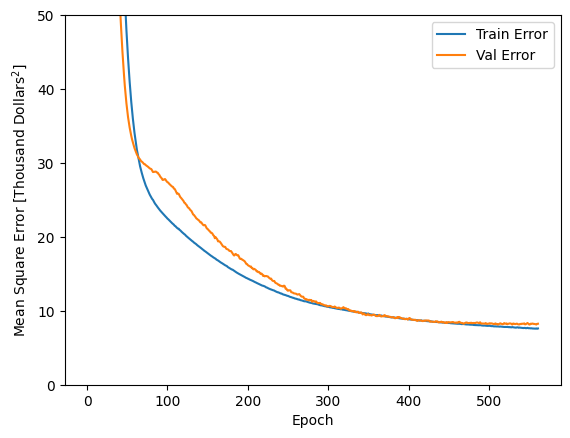

In [15]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

plot_history()

Next, compare how the model performs on the test dataset:

In [16]:
test_features_norm = (test_features - train_mean) / train_std
mse, _, _ = model.evaluate(test_features_norm, test_labels)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12.7812 - mae: 2.5127 - mse: 12.7812
Root Mean Square Error on test set: 4.017


Compare the RMSE measure you get to the [Kaggle leaderboard](https://www.kaggle.com/c/boston-housing/leaderboard). An RMSE of 2.651 puts us in 5th place.

## Part 2: Classification of MNIST Dreams with Convolutional Neural Networks

Next, let's build a convolutional neural network (CNN) classifier to classify images of handwritten digits in the MNIST dataset with a twist where we test our classifier on high-resolution hand-written digits from outside the dataset.

In [17]:
# Set common constants
this_repo_url = 'https://github.com/lexfridman/mit-deep-learning/raw/master/'
this_tutorial_url = this_repo_url + 'tutorial_deep_learning_basics'

The MNIST dataset containss 70,000 grayscale images of handwritten digits at a resolution of 28 by 28 pixels. The task is to take one of these images as input and predict the most likely digit contained in the image (along with a relative confidence in this prediction):

<img src="https://i.imgur.com/ITrm9x4.png" width="500px">

Now, we load the dataset. The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The *labels* are an array of integers, ranging from 0 to 9.

In [18]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# reshape images to specify that it's a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [19]:
def preprocess_images(imgs): # should work for both a single image and multiple images
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape # make sure images are 28x28 and single-channel (grayscale)
    return imgs / 255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

Display the first 5 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

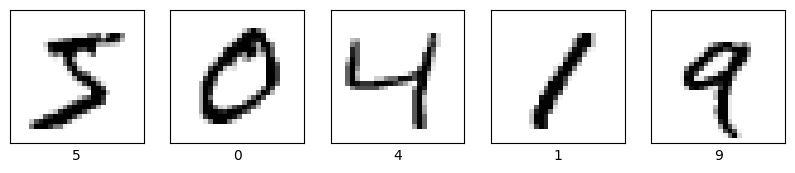

In [20]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model. In many cases, this can be reduced to simply stacking together layers:

In [21]:
model = keras.Sequential()
# 32 convolution filters used each of size 3x3
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 64 convolution filters used each of size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))
# choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
# flatten since too many dimensions, we only want a classification output
model.add(Flatten())
# fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
# one more dropout
model.add(Dropout(0.5))
# output a softmax to squash the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps. "accuracy" is the fraction of images that are correctly classified.

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_images` array. We verify that the predictions match the labels from the `test_labels` array.

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [25]:
history = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 180s 95ms/step - accuracy: 0.8807 - loss: 0.3685
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 179s 96ms/step - accuracy: 0.9747 - loss: 0.0838
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 201s 95ms/step - accuracy: 0.9814 - loss: 0.0593
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 177s 95ms/step - accuracy: 0.9848 - loss: 0.0494
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 177s 94ms/step - accuracy: 0.9873 - loss: 0.0424


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 98.68% on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [26]:
print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

(10000, 28, 28, 1)
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9876 - loss: 0.0388
Test accuracy: 0.9904999732971191


Often times, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*. In our case, the accuracy is better at 99.19%! This is, in part, due to successful regularization accomplished with the Dropout layers.

### Make predictions

With the model trained, we can use it to make predictions about some images. Let's step outside the MNIST dataset for that and go with the beautiful high-resolution images generated by a mixture of CPPN, GAN, VAE. See [great blog post by hardmaru](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/) for the source data and a description of how these morphed animations are generated:

![MNIST dream](https://i.imgur.com/OrUJs9V.gif)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


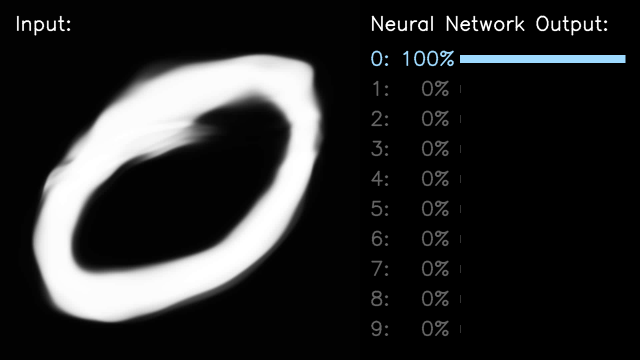

In [27]:
mnist_dream_path = 'images/mnist_dream.mp4'
mnist_prediction_path = 'images/mnist_dream_predicted.mp4'

# download the video if running in Colab
if not os.path.isfile(mnist_dream_path):
    print('downloading the sample video...')
    vid_url = this_tutorial_url + '/' + mnist_dream_path

    mnist_dream_path = urllib.request.urlretrieve(vid_url)[0]

def cv2_imshow(img):
    ret = cv2.imencode('.png', img)[1].tobytes()
    img_ip = IPython.display.Image(data=ret)
    IPython.display.display(img_ip)

cap = cv2.VideoCapture(mnist_dream_path)
vw = None
frame = -1 # counter for debugging (mostly), 0-indexed

# go through all the frames and run our classifier on the high res MNIST images as they morph from number to number
while True: # should 481 frames
    frame += 1
    ret, img = cap.read()
    if not ret: break

    assert img.shape[0] == img.shape[1] # should be a square
    if img.shape[0] != 720:
        img = cv2.resize(img, (720, 720))

    #preprocess the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_proc = cv2.resize(img_proc, (28, 28))
    img_proc = preprocess_images(img_proc)
    img_proc = 1 - img_proc # inverse since training dataset is white text with black background

    net_in = np.expand_dims(img_proc, axis=0) # expand dimension to specify batch size of 1
    net_in = np.expand_dims(net_in, axis=3) # expand dimension to specify number of channels

    preds = model.predict(net_in)[0]
    guess = np.argmax(preds)
    perc = np.rint(preds * 100).astype(int)

    img = 255 - img
    pad_color = 0
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))

    line_type = cv2.LINE_AA
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.3
    thickness = 2
    x, y = 740, 60
    color = (255, 255, 255)

    text = "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)

    text = "Input:"
    cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)

    y = 130
    for i, p in enumerate(perc):
        if i == guess: color = (255, 218, 158)
        else: color = (100, 100, 100)

        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)

        rect_start = 180
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = '{}: {:>3}%'.format(i, int(p))
        cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
        y += 60

    # if you don't want to save the output as a video, set this to False
    save_video = True

    if save_video:
        if vw is None:
            codec = cv2.VideoWriter_fourcc(*'DIVX')
            vid_width_height = img.shape[1], img.shape[0]
            vw = cv2.VideoWriter(mnist_prediction_path, codec, 30, vid_width_height)
        # 15 fps above doesn't work robustly so we right frame twice at 30 fps
        vw.write(img)
        vw.write(img)

    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)

cap.release()
if vw is not None:
    vw.release()

The above shows the prediction of the network by choosing the neuron with the highest output. While the output layer values add 1 to one, these do not reflect well-calibrated measures of "uncertainty". Often, the network is overly confident about the top choice that does not reflect a learned measure of probability. If everything ran correctly you should get an animation like this:

![MNIST dream predictions](https://i.imgur.com/eMF9FOG.gif)

## Acknowledgements

The contents of this tutorial is based on and inspired by the work of [TensorFlow team](https://www.tensorflow.org) (see their [Colab notebooks](https://www.tensorflow.org/tutorials/)), our [MIT Human-Centered AI team](https://hcai.mit.edu), and individual pieces referenced in the [MIT Deep Learning](https://deeplearning.mit.edu) course slides.